#Double Pendulum Simulation

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import matplotlib
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
import time

In [3]:
from ctrl.block import Condition
from ctrl.block.logger import Logger
from ctrl.block.clock import Clock
from ctrl.system.ode import ODE
from ctrl.block.linear import TimeVarying, Constant

In [4]:
m1 = 30/1000
l1 = 7.6/100
r1 = (5-(10-7.6)/2)/100

w1 = 10/100
d1 = 2.4/100
J1 = m1 * (w1**2 + d1**2) / 12

m2 = 44/1000

w2 = 25.4/100
d2 = 2.4/100
J2 = m2 * (w2**2 + d2**2) / 12

r2 = (25.4/2-1.25)/100

Jm = 0.004106
km = 0.006039
bm = 0.091503

g = 9.8

bPhi = 0
bTheta = 0

In [5]:
def MK(x,u):
    theta, phi, thetaDot, phiDot = x
    return (np.array([[J2+m2*r2**2, m2*r2*l1*math.cos(theta-phi)],
                      [m2*r2*l1*math.cos(theta-phi), J1+Jm+m1*r1**2+m2*l1**2]]),
            np.array([bTheta*thetaDot+m2*r2*(g*math.sin(theta)+l1*math.sin(theta-phi)*phiDot**2),
                      g*(m1*r1+m2*l1)*math.sin(phi)-m2*r2*l1*math.sin(theta-phi)*thetaDot**2+(bm+bPhi)*phiDot-km*u[0]]))

def ff(t, x, u):
    M, K = MK(x,u)
    return np.hstack((x[2:4], -la.solve(M,K)))

theta0, phi0 = 0+math.pi/6, 0
t0, x0, u0 = 0, np.array([theta0,phi0,0,0]), [0]
M,K = MK(x0,u0)
print(M)
print(K)
print(ff(t0,x0,u0))

[[ 0.00081552  0.00033159]
 [ 0.00033159  0.0044299 ]]
[ 0.0246862  0.       ]
[  0.           0.         -31.22064431   2.33695276]


In [6]:
sys = ODE(t0 = t0, x0 = x0, f = ff)

tk = 5
uk = [0]
yk = sys.update(tk, uk)

print('1. [{:3.2f}, {:3.2f}] = {}'.format(t0, tk, yk))

1. [0.00, 5.00] = [ 0.29687298  0.00517458 -2.16096464  0.08445188]


In [7]:
from ctrl import Controller
controller = Controller()

In [8]:
controller.reset()

Ts = 0.01
controller.add_source('clock',Clock(period = Ts),['clock'])

condition = Condition(lambda t : t < T)
controller.add_filter('condition',condition,['clock'],['is_running'])

controller.add_signals('tau','x')
controller.add_filter('ode', 
                      TimeVarying(ODE(t0 = t0, x0 = x0, f = ff)),
                      ['clock','tau'], ['x'])
controller.add_sink('logger',Logger(),['clock','x'])

In [9]:
controller.set_source('clock',reset=True)
T = 5 + Ts
controller.run()

log = controller.read_sink('logger')
t0 = log[0,0]
tk = log[-1,0]
yk = log[-1,1:]

print('2. [{:3.2f}, {:3.2f}] = {}'.format(t0, tk, yk))

2. [0.01, 5.01] = [ 0.29687369  0.00517458 -2.16096526  0.08445201]


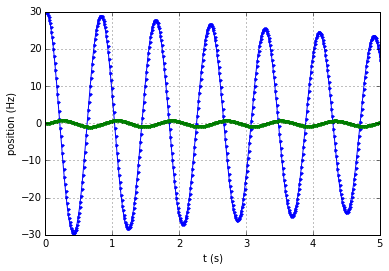

In [10]:
t = log[:,0]
theta = log[:,1]
phi = log[:,2]
thetaDot = log[:,3]
phiDor = log[:,4]

plt.plot(t, theta*180/math.pi, '.-', t, phi*180/math.pi, '.-')
plt.xlabel('t (s)')
plt.ylabel('position (Hz)')
plt.xlim(0,T)
plt.grid()

In [11]:
import control

eta = 0
phi = eta * math.pi

kappa = 0
theta = kappa * math.pi

numPhi = np.flipud(np.array([
        (-1)**kappa*g*km*m2*r2*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2),
        km*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)*bTheta, 
        km*(J2+m2*r2**2)*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)
    ]))

num = np.flipud(np.array([0, 0, 
                (-1)**(1+eta+kappa)*km*m2*r2*l1*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)
               ]))

den = np.flipud(np.array([
    (-1)**(eta+kappa)*g**2*m2*r2*(m1*r1+m2*l1)*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2),
    g*((-1)**eta*(m1*r1+m2*l1)*((-1)**(1+2*kappa)*m2**2*r2**2*l1**2+(J2+m2*r2**2)*(J1+Jm+m1*r1**2+m2*l1**2))*bTheta+(-1)**kappa*m2*r2*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)*(bm+bPhi)),
    g*((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)*((-1)**eta*(J2+m2*r2**2)*(m1*r1+m2*l1)+(-1)**kappa*m2*r2*(J1+Jm+m1*r1**2+m2*l1**2))+((-1)**(1+2*kappa)*m2**2*r2**2*l1**2+(J2+m2*r2**2)*(J1+Jm+m1*r1**2+m2*l1**2))*bTheta*(bm+bPhi),
    ((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)*((J1+Jm+m1*r1**2+m2*l1**2)*bTheta+(J2+m2*r2**2)*(bm+bPhi)),
    ((J1+Jm+m1*r1**2)*(J2+m2*r2**2)+J2*m2*l1**2)**2
    ]))

sys = control.tf((num-numPhi)/den[0], den/den[0])
print(sys)
print(control.zero(sys))
print(control.pole(sys))


             -2.088 s^2 - 86.02
--------------------------------------------
s^4 + 21.53 s^3 + 73.44 s^2 + 1303 s + 625.9

[ 0.+6.41858752j  0.-6.41858752j]
[-20.92788039+0.j        -0.05479326+7.797111j  -0.05479326-7.797111j
  -0.49195262+0.j      ]


In [12]:
fc = 20
wc = 2 * math.pi * fc
lpf = control.tf(wc,[1,wc])

ctr = -.8*100

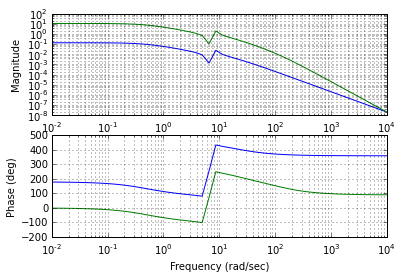

In [13]:
mag, phase, omega = control.bode_plot([sys, sys * ctr * lpf])

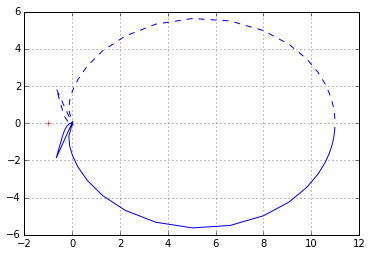

In [15]:
real, imag, freq = control.nyquist_plot(sys * ctr * lpf)
plt.grid()
#plt.xlim(-1,0)
#plt.ylim(-1,1)

In [16]:
cl = control.feedback(lpf * ctr * sys, 1)
pcl=control.pole(cl)
print(pcl)

[-127.22144829+0.j           -8.82384780+8.28020398j
   -8.82384780-8.28020398j   -1.16199088+7.02114713j
   -1.16199088-7.02114713j]


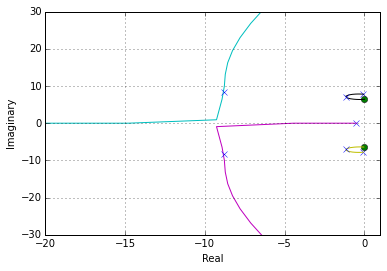

In [17]:
a = control.rlocus(lpf * sys * ctr)
plt.plot(pcl.real,pcl.imag,'x')
plt.xlim(-20,1)
plt.ylim(-30,30)
plt.grid()

In [18]:
def gg(t, x, u):
    return [x[0]-x[1]]

Ac, Bc, Cc, Dc = map(np.array, control.ssdata(control.ss(lpf * ctr)))
nc = Ac.shape[0]

def F(t, x, ref):
    x, xc = x[0:4], x[4:4+nc]
    y = ref - gg(t,x,[0])
    u = max(-100,min(100,Cc.dot(xc)+Dc.dot(y)))
    #print(ff(t,x,u))
    return np.hstack((ff(t,x,u), Ac.dot(xc)+Bc.dot(y)))

ref = eta * math.pi
ref = 10 * math.pi/180

theta0 = -20*math.pi/180
xx0 = [kappa*math.pi-theta0,eta*math.pi,0,0]
xc0 = np.zeros((nc,))
x0 = np.hstack((xx0,xc0))

t0 = 0
print('F = {}'.format(F(t0, x0, np.array([ref]))))

sys = ODE(t0 = t0, x0 = x0, f = F)

tk = 1
uk = np.array([0])
yk = sys.update(tk, uk)

print('1. [{:3.2f}, {:3.2f}] = {}'.format(t0, tk, yk))

F = [  0.           0.         -21.47574491   1.74426109  -0.17453293]
1. [0.00, 1.00] = [  4.81900981e-02   9.73781276e-02  -7.74503784e-01  -3.60624649e-02
   3.42651265e-04]


In [19]:
controller.reset()
controller.add_source('clock',Clock(period = Ts),['clock'])

condition = Condition(lambda t : t < T)
controller.add_filter('condition',condition,['clock'],['is_running'])

controller.add_signals('ref','x')
controller.add_filter('ode', 
                      TimeVarying(ODE(t0 = t0, x0 = x0, f = F)),
                      ['clock','ref'], ['x'])
controller.add_sink('logger',Logger(),['clock','x'])

In [20]:
controller.set_source('clock',reset=True)
controller.set_sink('logger',reset=True)
controller.set_signal('ref',ref)
T = 3 + Ts
controller.run()

log = controller.read_sink('logger')

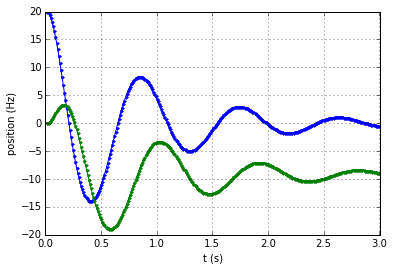

In [21]:
t = log[:,0]
theta = log[:,1]
phi = log[:,2]
thetaDot = log[:,3]
phiDot = log[:,4]

plt.plot(t, theta*180/math.pi, '.-', t, phi*180/math.pi, '.-')
plt.xlabel('t (s)')
plt.ylabel('position (Hz)')
plt.xlim(0,T)
plt.grid()